# Gesture Recognision
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
import datetime
import imageio
import matplotlib.pyplot as plt
from sys import getsizeof
%matplotlib inline

from PIL import Image, ImageFilter, ImageEnhance     #use Image.resize() for imresize()
import cv2
import abc

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, InputLayer, Rescaling, Dropout
from keras.layers import Conv3D, MaxPooling3D, LSTM, GlobalAveragePooling3D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [5]:
# Check available physical devices
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Global variables
project_folder='Project_data'

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/train'
val_path = project_folder + '/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Helper method to plot accuracy and loss history

In [7]:
def show_history(history, options):
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(options['num_epochs'])

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Default options to be used for each model

In [8]:
def get_default_options():
    return {
        "image_height": 120,
        "image_width": 120,
        "channels": 3,
        "num_classes": 5,
        "total_frames": 30,
        "frames_to_sample": 30,
        "batch_size": 20,
        "num_epochs": 20,
        "augment_data": False,
        "num_train_sequences": num_train_sequences,
        "num_val_sequences": num_val_sequences,
    }

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, options):
    img_idx = np.round(np.linspace(0, options['total_frames']-1, options['frames_to_sample'])).astype(int)
    batch_size = options['batch_size']
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
    
        for batch in range(num_batches): 
            batch_data, batch_labels= get_single_batch_data(source_path, options, t, batch, batch_size, img_idx)
            yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
    
        if (remaining_seq != 0):
            batch_data, batch_labels= get_single_batch_data(source_path, options, t, num_batches, batch_size, img_idx, remaining_seq)
            yield batch_data, batch_labels 


def get_single_batch_data(source_path, options, t, batch, batch_size, img_idx, remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size

    batch_data = np.zeros((seq_len,len(img_idx), options['image_height'], options['image_width'], options['channels'])) 
    batch_labels = np.zeros((seq_len, options['num_classes'])) 

    if (options['augment_data']):
        batch_data_aug = np.zeros((seq_len, len(img_idx), options['image_height'], options['image_width'], options['channels']))

    
    for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
            #performing image reading and resizing
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            image_resized = np.array(Image.fromarray((image * 1).astype(np.uint8)).resize((options['image_width'], options['image_height'])))
        
            #normalizing the images
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
        
            if (options['augment_data']):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped = shifted[x0:x1,y0:y1,:]
                
                image_resized = np.array(Image.fromarray((cropped * 1).astype(np.uint8))
                                         .resize((options['image_width'], options['image_height'])))
        
                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        

    if (options['augment_data']):
        batch_data = np.concatenate([batch_data,batch_data_aug])
        batch_labels = np.concatenate([batch_labels,batch_labels])

    
    return (batch_data, batch_labels)


Helper method to train a passed-in model

In [10]:
def train_model(model, options):
    train_generator = generator(train_path, train_doc, options)
    val_generator = generator(val_path, val_doc, options)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=True, save_weights_only=False, 
                                 mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
    callbacks_list = [ checkpoint, LR, earlystop ]

    if (options['num_train_sequences'] % options['batch_size']) == 0:
        steps_per_epoch = int(options['num_train_sequences']/options['batch_size'])
    else:
        steps_per_epoch = (options['num_train_sequences'] // options['batch_size']) + 1

    if (options['num_val_sequences'] % options['batch_size']) == 0:
        validation_steps = int(options['num_val_sequences'] / options['batch_size'])
    else:
        validation_steps = (options['num_val_sequences'] // options['batch_size']) + 1

    history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=options['num_epochs'], verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

## Conv3D Model

In [11]:
def get_conv3d_model(options):

    input_shape = (options['frames_to_sample'], options['image_height'], options['image_width'], options['channels'])

    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    ### commenting out BatchNormalization layers after Conv3D, as FusedBatchNormV3 doesn't work properly with Mac m1
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(options['num_classes'], activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model 1: Conv3D - finding out ideal image size and batch size

In [26]:
options = get_default_options()
options['image_height'] = 160
options['image_width'] = 160
options['frames_to_sample'] = 16
options['batch_size'] = 20
options['num_epochs'] = 4
options['augment_data'] = False


conv_3d1_model = get_conv3d_model(options)
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_16 (Activation)  (None, 16, 160, 160, 16   0         
                             )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 8, 80, 80, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 80, 80, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 80, 80, 32)     0         
                                                      

In [28]:
history = train_model(conv_3d1_model, options)

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.4139 - categorical_accuracy: 0.4268
Epoch 1: val_loss improved from inf to 13.01464, saving model to model_init_2023-09-0216_12_33.201463/model-00001-1.41389-0.42685-13.01464-0.28000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.4139 - categorical_accuracy: 0.4268 - val_loss: 13.0146 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 1.3502 - categorical_accuracy: 0.4691
Epoch 2: val_loss improved from 13.01464 to 3.84596, saving model to model_init_2023-09-0216_12_33.201463/model-00002-1.35019-0.46908-3.84596-0.21000.h5
34/34 [==============================] - 229s 7s/step - loss: 1.3502 - categorical_accuracy: 0.4691 - val_loss: 3.8460 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 1.1768 - categorical_accuracy: 0.5385
Epoch 3: val_loss improved from 3.84596 to 3.05

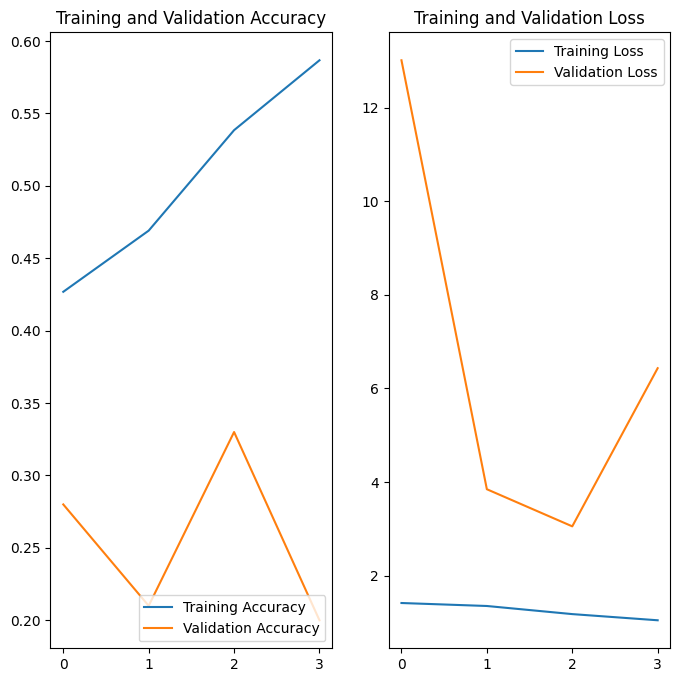

In [31]:
show_history(history, options)

### Observations
- Huge gap in training and validation accuracies, with high validation loss.

## Model 2: Reducing image size to 120x120

In [32]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 20
options['num_epochs'] = 4
options['augment_data'] = False

conv_3d1_model_2 = get_conv3d_model(options)
conv_3d1_model_2.summary()

history = train_model(conv_3d1_model_2, options)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 60, 60, 32)     0         
                                                      

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.8510 - categorical_accuracy: 0.3363
Epoch 1: val_loss improved from inf to 8.74793, saving model to model_init_2023-09-0216_29_38.046644/model-00001-1.85104-0.33635-8.74793-0.23000.h5
34/34 [==============================] - 119s 3s/step - loss: 1.8510 - categorical_accuracy: 0.3363 - val_loss: 8.7479 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 1.3833 - categorical_accuracy: 0.4540
Epoch 2: val_loss improved from 8.74793 to 4.85676, saving model to model_init_2023-09-0216_29_38.046644/model-00002-1.38334-0.45400-4.85676-0.23000.h5
34/34 [==============================] - 122s 4s/step - loss: 1.3833 - categorical_accuracy: 0.4540 - val_loss: 4.8568 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 1.2511 - categorical_accuracy: 0.5279
Epoch 3: val_loss did not improve from 4.85676
34/3

### Observations
- Reducing image size to 120x120 reduced the training time by half.

## Model 3: Decreased batch size and increased number of epochs to 10

In [13]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = False

conv_3d1_model_3 = get_conv3d_model(options)
conv_3d1_model_3.summary()

history = train_model(conv_3d1_model_3, options)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 8, 60, 60, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)     0         
                                                      

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.7471 - categorical_accuracy: 0.3560
Epoch 1: val_loss improved from inf to 8.81149, saving model to model_init_2023-09-0216_52_46.864076/model-00001-1.74709-0.35596-8.81149-0.23000.h5
67/67 [==============================] - 116s 2s/step - loss: 1.7471 - categorical_accuracy: 0.3560 - val_loss: 8.8115 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.4045 - categorical_accuracy: 0.4208
Epoch 2: val_loss improved from 8.81149 to 1.94729, saving model to model_init_2023-09-0216_52_46.864076/model-00002-1.40449-0.42081-1.94729-0.38000.h5
67/67 [==============================] - 115s 2s/step - loss: 1.4045 - categorical_accuracy: 0.4208 - val_loss: 1.9473 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.2109 - categorical_accuracy: 0.5279
Epoch 3: val_loss improved from 1.94729 to 1.457

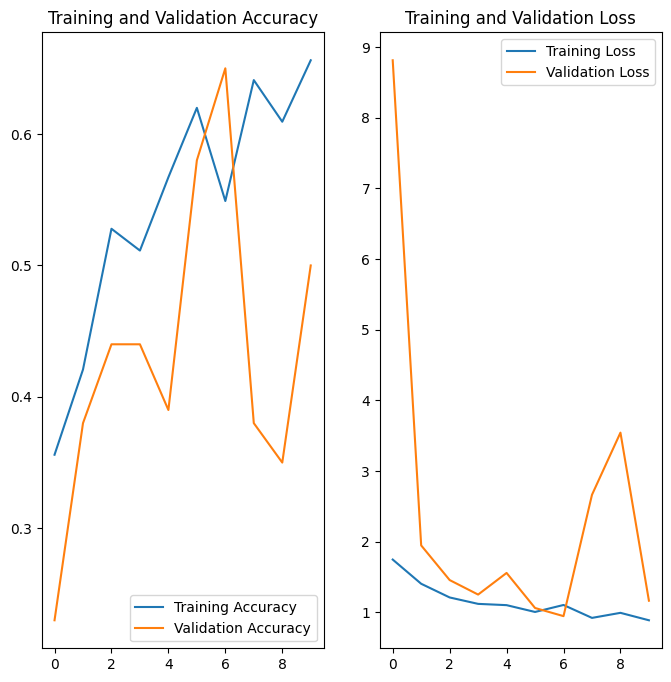

In [17]:
show_history(history, options)

### Observations
- Number of epochs too low to comment on overfitting.
- The accuracies and losses seem to merge as expected in this experiment.
- Batch size didn't seem to affect the training time.

## Model 4: Increased number of frames to sample

In [ ]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 30
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = False

conv_3d1_model_4 = get_conv3d_model(options)
conv_3d1_model_4.summary()

history = train_model(conv_3d1_model_4, options)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 60, 60, 32)    0         
                                                        

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.8054 - categorical_accuracy: 0.3303
Epoch 1: val_loss improved from inf to 9.77640, saving model to model_init_2023-09-0217_59_36.494833/model-00001-1.80543-0.33032-9.77640-0.23000.h5
67/67 [==============================] - 215s 3s/step - loss: 1.8054 - categorical_accuracy: 0.3303 - val_loss: 9.7764 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.4341 - categorical_accuracy: 0.4118
Epoch 2: val_loss improved from 9.77640 to 3.54683, saving model to model_init_2023-09-0217_59_36.494833/model-00002-1.43409-0.41176-3.54683-0.24000.h5
67/67 [==============================] - 219s 3s/step - loss: 1.4341 - categorical_accuracy: 0.4118 - val_loss: 3.5468 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.2112 - categorical_accuracy: 0.5128
Epoch 3: val_loss improved from 3.54683 to 1.523

#### Resuming training after kernel restarted automatically due to some unknown reason
I suspect there's a memory leak somewhere; due to time constraints, I'm ignoring it for now.

In [10]:
from keras.models import load_model
def resume_training(model_path, options):
    model_to_resume_training = load_model(model_path)
    train_generator = generator(train_path, train_doc, options)
    val_generator = generator(val_path, val_doc, options)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
    callbacks_list = [ LR, earlystop ]

    if (options['num_train_sequences'] % options['batch_size']) == 0:
        steps_per_epoch = int(options['num_train_sequences']/options['batch_size'])
    else:
        steps_per_epoch = (options['num_train_sequences'] // options['batch_size']) + 1

    if (options['num_val_sequences'] % options['batch_size']) == 0:
        validation_steps = int(options['num_val_sequences'] / options['batch_size'])
    else:
        validation_steps = (options['num_val_sequences'] // options['batch_size']) + 1
    history=model_to_resume_training.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=options['num_epochs'], verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

In [15]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 5     # training for only the remaining epochs
options['augment_data'] = False
model_path = 'model_init_2023-09-0217_59_36.494833/model-00008-0.92889-0.61991-0.99101-0.61000.h5'
history = resume_training(model_path, options)

Epoch 1/10
67/67 [==============================] - 117s 2s/step - loss: 0.8022 - categorical_accuracy: 0.6878 - val_loss: 1.4032 - val_categorical_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 2/10
67/67 [==============================] - 115s 2s/step - loss: 0.8147 - categorical_accuracy: 0.6923 - val_loss: 1.0540 - val_categorical_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 3/10
67/67 [==============================] - 118s 2s/step - loss: 0.7623 - categorical_accuracy: 0.6998 - val_loss: 1.0537 - val_categorical_accuracy: 0.6000 - lr: 2.0000e-04
Epoch 4/10
67/67 [==============================] - 118s 2s/step - loss: 0.7684 - categorical_accuracy: 0.7179 - val_loss: 1.8126 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 5/10
67/67 [==============================] - 117s 2s/step - loss: 0.8081 - categorical_accuracy: 0.6817 - val_loss: 1.7058 - val_categorical_accuracy: 0.4800 - lr: 2.0000e-04
Epoch 6/10
67/67 [==============================] - 119s 2s/step - loss: 0.7707 - categori

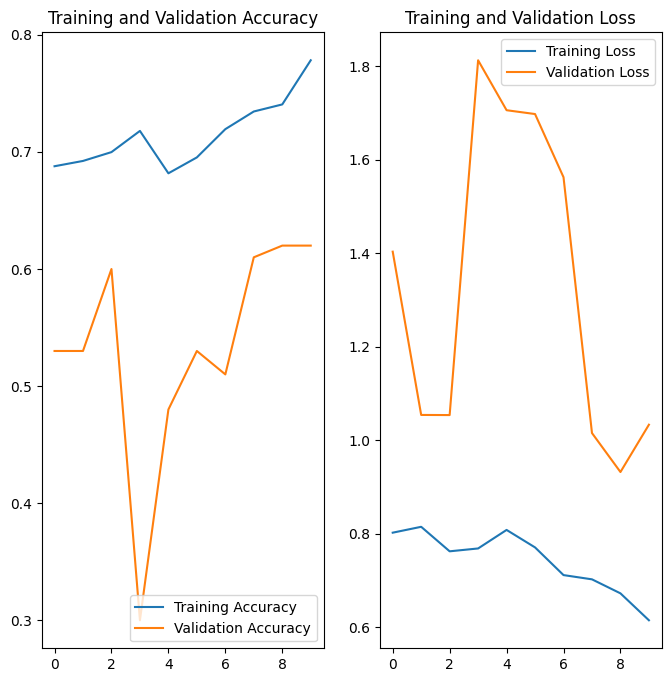

In [16]:
show_history(history, options)

### Observations
- Increasing number of frames increased training time as expected.
- The validation loss doesn't not seem to go down after a certain value compared to the training loss.
- Also the training accuracy keeps on increasing, but validation accuracy keeps hovering around 60%.
- This means that the model may be overfitting.

## Notes:
- We'll keep the frames_to_sample at 16, batch_size at 10 and image size at 120x120 as the model seems to be training faster with these.
- We'll tweek these values, if required, for different types models like CNN+RNN and while using TransferLearning.

## CNN+RNN Model

In [12]:
def get_cnn_rnn_model(options, lstm_cells=64, dense_neurons=64, dropout=0.25):

    input_shape = (options['frames_to_sample'], options['image_height'], options['image_width'], options['channels'])

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(options['num_classes'], activation='softmax'))
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [13]:
# similar to above LSTM based model, but using GRU here
def get_cnn_rnn_gru_model(options, gru_cells=64, dense_neurons=64, dropout=0.25):

    input_shape = (options['frames_to_sample'], options['image_height'], options['image_width'], options['channels'])

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(options['num_classes'], activation='softmax'))
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

## Model 5: CNN+RNN Model with TimeDistributed Conv2D and LSTM layers

In [18]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = False

cnn_rnn_model_1 = get_cnn_rnn_model(options)
cnn_rnn_model_1.summary()

history = train_model(cnn_rnn_model_1, options)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 16, 60, 60, 32)    1

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4816 - categorical_accuracy: 0.3514
Epoch 1: val_loss improved from inf to 1.85921, saving model to model_init_2023-09-0219_26_18.259641/model-00001-1.48156-0.35143-1.85921-0.25000.h5
67/67 [==============================] - 38s 523ms/step - loss: 1.4816 - categorical_accuracy: 0.3514 - val_loss: 1.8592 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.3528 - categorical_accuracy: 0.4148
Epoch 2: val_loss improved from 1.85921 to 1.80712, saving model to model_init_2023-09-0219_26_18.259641/model-00002-1.35280-0.41478-1.80712-0.21000.h5
67/67 [==============================] - 30s 448ms/step - loss: 1.3528 - categorical_accuracy: 0.4148 - val_loss: 1.8071 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.3398 - categorical_accuracy: 0.4253
Epoch 3: val_loss did not improve from 1.807

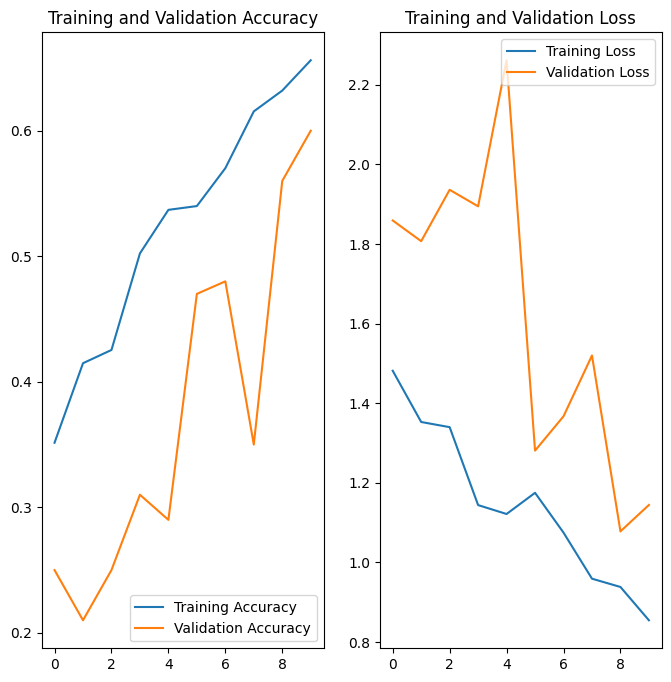

In [19]:
show_history(history, options)

#### Observations
- Since we're not using a Conv3D model, but a time distributed Conv2D one now, the training time has reduced drasitcally.
- We've achieved decent accuracies with 10 epochs so far.
- Training this model for even more epochs would help us understand if any overfitting is present.

## Model 6: CNN+RNN Model with 

In [14]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = False

cnn_rnn_model_2 = get_cnn_rnn_gru_model(options)
cnn_rnn_model_2.summary()

history = train_model(cnn_rnn_model_2, options)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 16, 60, 60, 32)    1

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.7376 - categorical_accuracy: 0.3318
Epoch 1: val_loss improved from inf to 2.55792, saving model to model_init_2023-09-0222_59_08.741231/model-00001-1.73755-0.33183-2.55792-0.25000.h5
67/67 [==============================] - 43s 544ms/step - loss: 1.7376 - categorical_accuracy: 0.3318 - val_loss: 2.5579 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.3004 - categorical_accuracy: 0.4600
Epoch 2: val_loss did not improve from 2.55792
67/67 [==============================] - 34s 509ms/step - loss: 1.3004 - categorical_accuracy: 0.4600 - val_loss: 2.6066 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1749 - categorical_accuracy: 0.5324
Epoch 3: val_loss improved from 2.55792 to 2.36684, saving model to model_init_2023-09-0222_59_08.741231/model-00003-1.17490-0.53243-2.36684-0.25000.

In [ ]:
show_history(history, options)

#### Observations
- Definitely faster than previous LSTM based model.
- Validation accuracy is poor compared to previous model.
- Overfitting is suspected, training for more number of epochs would confirm that.

## With Data Augmentation
Let's run the previous two models along with data augmentation and epochs=20 to see if see any improvements.

## Model 7: CNN+LSTM with data augmentation and increased epochs=20

In [ ]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 20
options['augment_data'] = True

cnn_rnn_model_1a = get_cnn_rnn_model(options)
cnn_rnn_model_1a.summary()

history = train_model(cnn_rnn_model_1a, options)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 16, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_33 (TimeD  (None, 16, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_34 (TimeD  (None, 16, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 16, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 16, 60, 60, 32)   

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4797 - categorical_accuracy: 0.3529
Epoch 1: val_loss improved from inf to 1.68169, saving model to model_init_2023-09-0219_45_25.606752/model-00001-1.47972-0.35294-1.68169-0.17500.h5
67/67 [==============================] - 58s 835ms/step - loss: 1.4797 - categorical_accuracy: 0.3529 - val_loss: 1.6817 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2910 - categorical_accuracy: 0.4480
Epoch 2: val_loss did not improve from 1.68169
67/67 [==============================] - 54s 804ms/step - loss: 1.2910 - categorical_accuracy: 0.4480 - val_loss: 1.7704 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2047 - categorical_accuracy: 0.4796
Epoch 3: val_loss did not improve from 1.68169
67/67 [==============================] - 53s 791ms/step - loss: 1.2047 - categorical_accuracy: 0.4796 

In [13]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 5     # training for only the remaining epochs
options['augment_data'] = True
model_path = 'model_init_2023-09-0219_45_25.606752/model-00014-0.56096-0.80317-0.57750-0.74500.h5'
history = resume_training(model_path, options)

Epoch 1/5
67/67 [==============================] - 54s 795ms/step - loss: 0.5022 - categorical_accuracy: 0.8288 - val_loss: 0.7203 - val_categorical_accuracy: 0.7200 - lr: 2.0000e-04
Epoch 2/5
67/67 [==============================] - 53s 788ms/step - loss: 0.5140 - categorical_accuracy: 0.8205 - val_loss: 0.6644 - val_categorical_accuracy: 0.7400 - lr: 2.0000e-04
Epoch 3/5
67/67 [==============================] - 54s 808ms/step - loss: 0.4791 - categorical_accuracy: 0.8311 - val_loss: 0.7619 - val_categorical_accuracy: 0.7200 - lr: 2.0000e-04
Epoch 4/5
67/67 [==============================] - 50s 755ms/step - loss: 0.4168 - categorical_accuracy: 0.8582 - val_loss: 0.6771 - val_categorical_accuracy: 0.7450 - lr: 2.0000e-04
Epoch 5/5
67/67 [==============================] - 49s 729ms/step - loss: 0.3768 - categorical_accuracy: 0.8824 - val_loss: 0.5301 - val_categorical_accuracy: 0.8100 - lr: 2.0000e-04


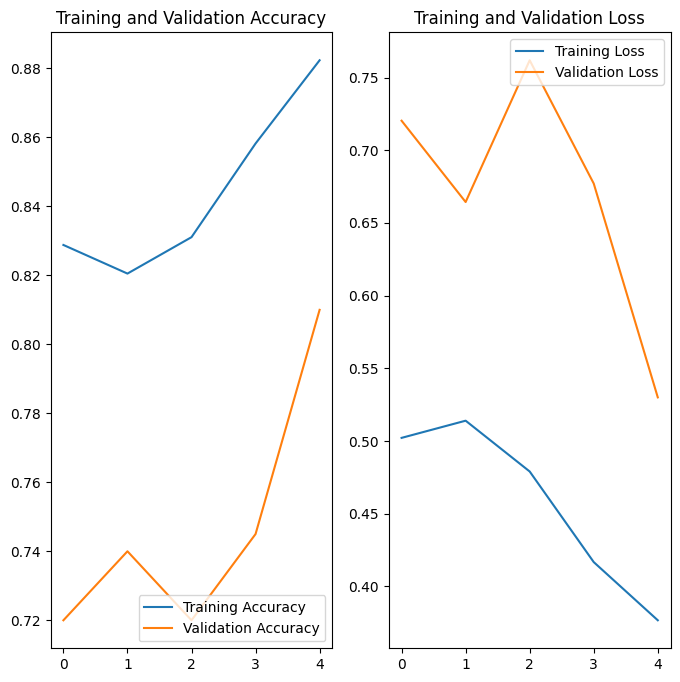

In [14]:
show_history(history, options)

#### Observations
- The training and validation accuracies seems to be going in the right direction.
- Training this model for even more epochs would tell us how much accuracies improve further and if there's any overfitting present in the model.

## Model 8: CNN+GRU with data augmentation and increased epochs=20

In [15]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = True

cnn_rnn_model_2a = get_cnn_rnn_model(options)
cnn_rnn_model_2a.summary()

history = train_model(cnn_rnn_model_2a, options)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 16, 60, 60, 32)    1

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4754 - categorical_accuracy: 0.3499
Epoch 1: val_loss improved from inf to 1.93081, saving model to model_init_2023-09-0220_08_18.002583/model-00001-1.47545-0.34992-1.93081-0.16000.h5
67/67 [==============================] - 59s 852ms/step - loss: 1.4754 - categorical_accuracy: 0.3499 - val_loss: 1.9308 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2557 - categorical_accuracy: 0.4691
Epoch 2: val_loss did not improve from 1.93081
67/67 [==============================] - 54s 811ms/step - loss: 1.2557 - categorical_accuracy: 0.4691 - val_loss: 2.4040 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1186 - categorical_accuracy: 0.5505
Epoch 3: val_loss did not improve from 1.93081
67/67 [==============================] - 54s 815ms/step - loss: 1.1186 - categorical_accuracy: 0.5505 

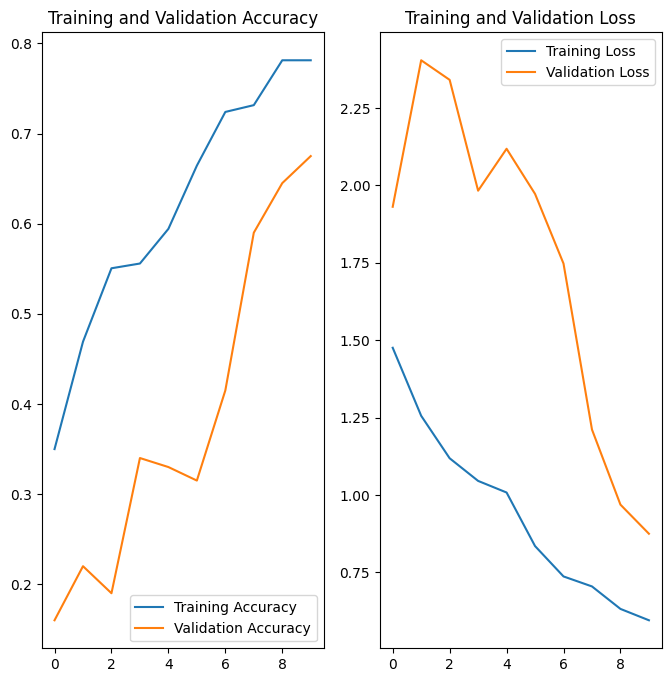

In [16]:
show_history(history, options)

#### Observations
- The training and validation accuracies seems to be going in the right direction.
- Training this model for even more epochs would tell us how much accuracies improve further and if there's any overfitting present in the model.
- Since this is GRU based model, its training time is definitely less than LSTM based one.

## Using Transfer Learning - mobilenet and vgg16

In [12]:
def get_transfer_learning_based_model(options, transfer_layer, is_transfer_layer_trainable=False,
                                      gru_cells=64, dense_neurons=64, dropout=0.25):

    input_shape = (options['frames_to_sample'], options['image_height'], options['image_width'], options['channels'])

    model = Sequential()
    model.add(TimeDistributed(transfer_layer, input_shape=input_shape))
    
    if not is_transfer_layer_trainable:
        for layer in model.layers:
            layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(options['num_classes'], activation='softmax'))
    
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model 9: Using non-trainable VGG16 transfer learning layer

In [24]:
from keras.applications.vgg16 import VGG16
vgg16_transfer = VGG16(weights='imagenet', include_top=False)

options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = True

vgg16_model = get_transfer_learning_based_model(options, vgg16_transfer, is_transfer_layer_trainable=False)
vgg16_model.summary()

history = train_model(vgg16_model, options)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 16, 3, 3, 512)     14714688  
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 16, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 16, 1, 1, 512)     0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 16, 512)           0         
 istributed)                                                     
                                                                 
 gru_2 (GRU)                 (None, 64)               

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.7877 - categorical_accuracy: 0.2790
Epoch 1: val_loss improved from inf to 1.43117, saving model to model_init_2023-09-0220_31_50.747014/model-00001-1.78774-0.27903-1.43117-0.38500.h5
67/67 [==============================] - 100s 1s/step - loss: 1.7877 - categorical_accuracy: 0.2790 - val_loss: 1.4312 - val_categorical_accuracy: 0.3850 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2134 - categorical_accuracy: 0.5090
Epoch 2: val_loss improved from 1.43117 to 1.25186, saving model to model_init_2023-09-0220_31_50.747014/model-00002-1.21339-0.50905-1.25186-0.49500.h5
67/67 [==============================] - 98s 1s/step - loss: 1.2134 - categorical_accuracy: 0.5090 - val_loss: 1.2519 - val_categorical_accuracy: 0.4950 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.9737 - categorical_accuracy: 0.6192
Epoch 3: val_loss improved from 1.25186 to 1.0039

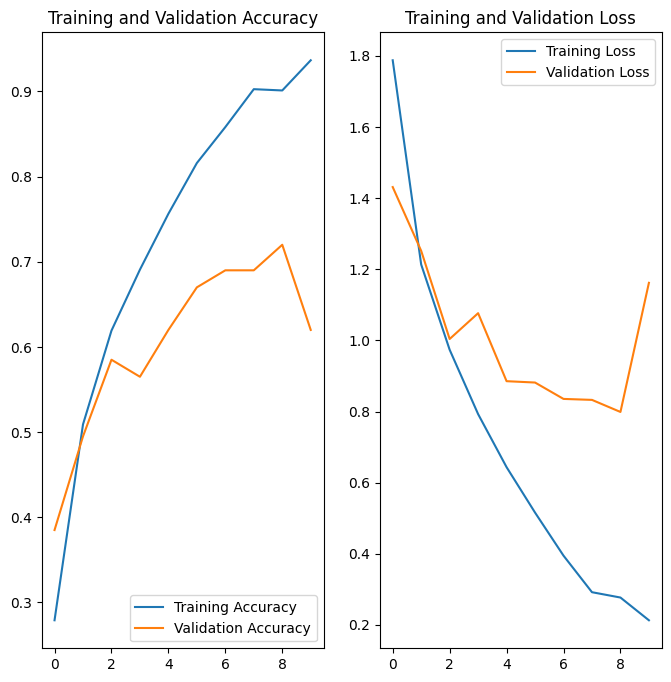

In [25]:
show_history(history, options)

#### Observations
- There's a clear evidence of model overfitting here. 
- Within 10 epochs, the training accuracy shot up to 94%, but the validation accuracy is hovering around 70%.
- This is with data augmentation, I doubt it'd improve without data augmentation as well.

## Model 10: Using non-trainable MobileNet transfer learning layer

In [14]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 10
options['augment_data'] = True

mobilenet_model = get_transfer_learning_based_model(options, mobilenet_transfer, is_transfer_layer_trainable=False)
mobilenet_model.summary()

history = train_model(mobilenet_model, options)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 16, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 16, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 16, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 16, 1024)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.5532 - categorical_accuracy: 0.3899
Epoch 1: val_loss improved from inf to 1.29817, saving model to model_init_2023-09-0221_11_02.488454/model-00001-1.55319-0.38989-1.29817-0.45500.h5
67/67 [==============================] - 55s 814ms/step - loss: 1.5532 - categorical_accuracy: 0.3899 - val_loss: 1.2982 - val_categorical_accuracy: 0.4550 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.9815 - categorical_accuracy: 0.6124
Epoch 2: val_loss improved from 1.29817 to 0.78138, saving model to model_init_2023-09-0221_11_02.488454/model-00002-0.98155-0.61237-0.78138-0.72000.h5
67/67 [==============================] - 53s 800ms/step - loss: 0.9815 - categorical_accuracy: 0.6124 - val_loss: 0.7814 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.6586 - categorical_accuracy: 0.7564
Epoch 3: val_loss improved from 0.78138 to 0

#### Observations
- Training time is lower compared to VGG16 based model.
- There's a clear evidence of model overfitting here. 
- Within 10 epochs, the training accuracy shot up to 95%, but the validation accuracy is hovering around 75%.
- This is with data augmentation, I doubt it'd improve without data augmentation as well.

### Training the best model so far for 5 more epochs

In [13]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 5
options['augment_data'] = True

model_path = 'model_init_2023-09-0221_48_37.865319/model-00005-0.37450-0.86727-0.53111-0.78500.h5'
model_to_resume_training = load_model(model_path)
history = train_model(model_to_resume_training, options)

Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 0.3498 - categorical_accuracy: 0.8937
Epoch 1: val_loss improved from inf to 0.64469, saving model to model_init_2023-09-0222_14_09.776088/model-00001-0.34983-0.89367-0.64469-0.74500.h5
67/67 [==============================] - 54s 797ms/step - loss: 0.3498 - categorical_accuracy: 0.8937 - val_loss: 0.6447 - val_categorical_accuracy: 0.7450 - lr: 2.0000e-04
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 0.3262 - categorical_accuracy: 0.9005
Epoch 2: val_loss improved from 0.64469 to 0.59432, saving model to model_init_2023-09-0222_14_09.776088/model-00002-0.32623-0.90045-0.59432-0.79500.h5
67/67 [==============================] - 52s 788ms/step - loss: 0.3262 - categorical_accuracy: 0.9005 - val_loss: 0.5943 - val_categorical_accuracy: 0.7950 - lr: 2.0000e-04
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.2780 - categorical_accuracy: 0.9201
Epoch 3: val_loss improved from 0.59432

#### Observations
- Validation accuracy not improving beyoud 79.5%, whereas training accuracy keeps on increasing.
- Training for more epochs would result in model overfitting beyond what it has already done.
- To overcome overfitting, more data augmentation can be done along with more normalization layers.
- The transfer learning layer can be made trainable, it might reduce the overfitting as well.

## Loading the final model and testing

In [15]:
model_path = 'model_init_2023-09-0222_14_09.776088/model-00005-0.23954-0.92685-0.56141-0.79500.h5'
final_model = load_model(model_path)

In [16]:
options = get_default_options()
options['image_height'] = 120
options['image_width'] = 120
options['frames_to_sample'] = 16
options['batch_size'] = 10
options['num_epochs'] = 1
options['augment_data'] = False
val_generator = generator(val_path, val_doc, options)

batch_data, batch_labels = next(val_generator)

In [17]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
print(np.argmax(final_model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 0s 368ms/step
[3 3 0 2 2 4 2 1 0 1]
